<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">


# Text Classification using XGBoost and TfidfVectorizer

This Code Template is for Text Classification using XGBoost along with the Text Feature technique TfidfVectorizer from Scikit-learn in python. TF-IDF stands for Term Frequency — Inverse Document Frequency. It is a technique to quantify words in a set of documents. 

### Required Packages

In [ ]:
!pip install nltk
!pip install xgboost

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as se
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix,classification_report
from xgboost import XGBClassifier

### Initialization

Filepath of CSV file

In [18]:
#filepath
file_path= ''

**Target** variable for prediction.

In [22]:
target=''

Text column containing all the text data


In [23]:
text=""

## Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [24]:
df=pd.read_csv(file_path)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [28]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def textfinalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

def data_preprocess(df, target):
    df = df.dropna(axis=0, how = 'any')
    df[target] = LabelEncoder().fit_transform(df[target])    
    return df

In [29]:
df = data_preprocess(df, target)
df[text] = df[text].apply(lambda x: textfinalpreprocess(x))
df.head()

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah think go usf life around though


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X and target/outcome to Y.

In [30]:
X=df[text]
Y=df[target]

#### Distribution Of Target Variable

<AxesSubplot:xlabel='Category', ylabel='count'>

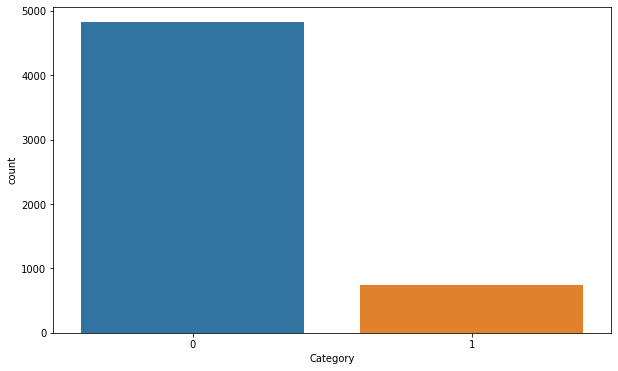

In [31]:
plt.figure(figsize = (10,6))
se.countplot(Y)

### Data Splitting
Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [32]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

### Feature Transformation

**TfidfVectorizer** 

Convert a collection of raw documents to a matrix of TF-IDF features.
Equivalent to CountVectorizer followed by TfidfTransformer.

[For More Reference](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [34]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)

In [35]:
x_train,y_train = RandomOverSampler(random_state=123).fit_resample(x_train, y_train)

## Model

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.


#### Model Tuning Parameters
 > - booster ->  Which booster to use. Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions.
 
 > - validate_parameters ->  When set to True, XGBoost will perform validation of input parameters to check whether a parameter is used or not. The feature is still experimental. Itâ€™s expected to have some false positives.

> - num_pbuffer ->  Size of prediction buffer, normally set to number of training instances. The buffers are used to save the prediction results of last boosting step.

> - num_feature ->  Feature dimension used in boosting, set to maximum dimension of the feature

For More Info [xgboost.readthedocs.io](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [36]:
model=XGBClassifier()
model.fit(x_train,y_train)

[16:57:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Model Accuracy
score() method return the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

In [37]:
print("Accuracy score {:.2f} %\n".format(model.score(x_test,y_test)*100))

Accuracy score 98.12 %



#### Confusion Matrix
A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

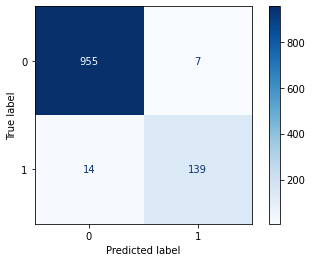

In [38]:
plot_confusion_matrix(model,x_test,y_test,cmap=plt.cm.Blues)

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.
* where:
  - Precision:- Accuracy of positive predictions.
  -  Recall:- Fraction of positives that were correctly identified.
  -  f1-score:- percent of positive predictions were correct
  -  support:- Support is the number of actual occurrences of the class in the specified dataset.

In [39]:
print(classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       962
           1       0.95      0.91      0.93       153

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115




#### Creator: Jay Shimpi , Github: [Profile](https://github.com/JayShimpi22)